<h1 align="center"> Computación Cientifica - Laboratorio 3: Simulando Númericamente Sistemas Dinámicos </h1>
<br>
<br>
** Autores **:
+ Yerson Escobar - 201273084-8 
+ Eduardo Ramírez - 201103031-1


## Introducción

Dentro de este laboratorio, exploraremos los que son los métodos de resolución de ecuaciones diferenciales parciales (ODE). Dentro de los métodos de resolución veremos los que son para problemas de valor inicial (IVP), los cuales son: Euler, MidPoint (Runge-Kutta 2) y Runge-Kutta 4. Para estos métodos, veremos cuáles son sus ventajas y desventajas y que factores pueden variar en el resultado, tiempos de ejecución y uso de memoria en base al \emph{Atractor de Lorenz}, el cual se puede representar como un sistema de 3 EDO's IVP. Por otro lado también veremos el método de resolución de ODE's para problemas de valor de frontera (BVP): Diferencias finitas, en donde veremos los pasos a desarrollar, s implementación y analisaremos que factores afectan la precisión del resultado entregado por este método. 

## Desarrollo

### Simulando sistemas caóticos

### Módulos y funciones necesarias

In [3]:
import numpy as np
from scipy import integrate
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from matplotlib import pyplot
from matplotlib import pyplot as plt
from pylab import plot
from numpy import linalg as LA
%load_ext memory_profiler
%load_ext line_profiler

# Como nunca se pudo hacer funcionar los magic para incluir as animaciones en el
# notebook, se incluyeron las imagenes de la simulación al finalizar.
# No cargar el magic %matplotlib inline del input 15 si se quieren probar las simulaciones posteriores

ImportError: No module named memory_profiler

### Función para visualizar resultados

In [2]:
"""
-> x_t
   arreglo con las posiciones (x,y,z) de las trayectorias. Este puede ser
   de dos dimensiones (len(t), 3) para una sola trayectoria, o puede ser 
   de tres dimensiones (len(t), 3, N_trajectories) para mas de una trayectoria
-> N_trajectories
   numero de trayectorias a visualizar
-> xlim,ylim,zlim
   limites en los ejes x,y,z de la animacion
-> rotate
   rotar mientras anima para mejores perspectivas
"""
def animate_lorenz(x_t, N_trajectories, xlim=(-20,70), ylim=(-35,35), zlim=(-35,35), rotate=False):
    #setting it to correct format
    if x_t.ndim==2:
        x_t = np.array([x_t])
    elif x_t.ndim==3: 
        x_t = np.rot90(x_t).T
    else:
        return -1
    #setting the number of frames
    frames = max(x_t.shape)
    frames /= 2
    #set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    #ax.axis('off')

    #choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

    #set up lines and points
    lines = sum([ax.plot([], [], [], '-', c=c)
                 for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', c=c)
               for c in colors], [])

    #prepare the axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    #set point-of-view: specified by (altitude degrees, azimuth degrees)
    ax.view_init(30, 0)

    #initialization function: plot the background of each frame
    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])

            pt.set_data([], [])
            pt.set_3d_properties([])
        return lines + pts

    #animation function.  This will be called sequentially with the frame number
    def animate(i):
        # we'll step two time-steps per frame.  This leads to nice results.
        i = (2 * i) % x_t.shape[1]

        for line, pt, xi in zip(lines, pts, x_t):
            x, y, z = xi[:i].T
            line.set_data(x, y)
            line.set_3d_properties(z)

            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])

        if rotate: ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts

    #instantiate the animator.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=30, blit=True, repeat=False)
    #show it
    ax.set_title('Lorenz Simulation')
    ax.set_xlabel('x(t)')
    ax.set_ylabel('y(t)')
    ax.set_zlabel('z(t)')
    plt.show()

a.-

In [3]:
def euler_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0] = y0 
    for i in range(1, t_size):
        solutions[i] = solutions[i-1]+h*func(t[i-1],solutions[i-1])
    return solutions

def midpoint_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0, :] = y0 
    for i in range(1, t_size):
        current_t = t[i-1]
        y = solutions[i-1]
        k1 = y + h/2.0*func(current_t,y)
        solutions[i] = y + h*func(current_t + h/2.0,k1)
    return solutions

def RK4_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0, :] = y0
    for i in range(1, t_size):
        current_t = t[i-1]
        y = solutions[i-1]
        k1=func(current_t,y)
        k2=func(current_t+h/2.0,y+(h/2.0)*k1)        
        k3=func(current_t+h/2.0,y+(h/2.0)*k2)
        k4=func(current_t+h,y+h*k3)
        solutions[i] = y+(h/6.0)*(k1+2*k2+2*k3+k4)
    return solutions

b.- Se analizaran los valores de $h$ con que el sistema podrá ser solucionado 

$$
\vec{F}(\vec{x}) = 
\left( \begin{array}{c}
\sigma(y-x) \\
x(\rho-z)-y \\
xy - \beta z \end{array} \right)
\Longrightarrow
\partial\vec{F}(\vec{x}) =
\left( \begin{array}{ccc}
-\sigma & \sigma & 0\\
\rho-z & -1 & -x \\
y & x & -\beta\end{array} \right)
$$

Si los parametros son como se indica en el enunciado y $\vec{x_0} = (1,1,1)$ entonces

$$
\left|\partial\vec{F}(\vec{x_0}) - \lambda I \right| = -\lambda ^3-\frac{41 \lambda ^2}{3}+\frac{689 \lambda }{3}+\frac{2020}{3}
$$

Encontrando las raices:
$$
\lambda_1 = 11.4713 - 7.10543\cdot10^{-15} i
$$
$$
\lambda_2 = -22.533 - 5.32907\cdot10^{-15} i
$$
$$
\lambda_3 = -2.60495 + 1.24345\cdot10^{-14} i
$$

Dado que $h\lambda$ (con $\lambda$ negativo) debe estar en la región de estabilidad y despreciando la parte imaginaria, $h$ debe cumplir

$$
0 < h < 0.088
$$
$$
0 < h < 0.768
$$

Entonces $h = 0.087$


In [4]:
def LorentzAtractor(t, xvect):
    _x = xvect[0]
    _y = xvect[1]
    _z = xvect[2]
    next_x = sigma*(_y-_x)
    next_y = _x*(rho-_z)-_y
    next_z = _x*_y - beta*_z
    return np.array([next_x,next_y,next_z])
    
sigma = 10
rho = 28
beta = 8/3
xvect0 = np.array([1.0, 1.0, 1.0])

# El mejor h que funciona con todos fue encontrado por ensayo y error usando Euler.
# Los otros dos métodos, al tener mejor región de estabilidad, también funcionan con este h, aun que cada uno tiene su propia cota
# encontrada de la misma forma. 
h = 0.024

t = np.arange(0,100,h)

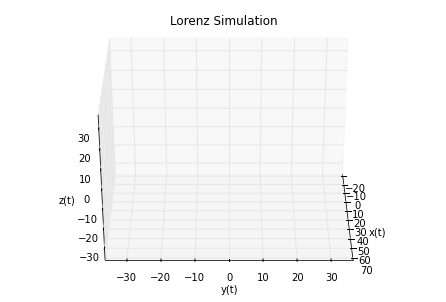

In [59]:
x_euler = euler_ode(LorentzAtractor,xvect0,t,h) #desestabiliza con h>= 0.025
animate_lorenz(x_euler,1)

<img src="images/euler.png">

In [ ]:
x_midpoint = midpoint_ode(LorentzAtractor,xvect0,t,h) #desestabiliza con h >=  0.07
animate_lorenz(x_midpoint,1)

<img src="images/midpoint.png">

In [ ]:
x_RK4 = RK4_ode(LorentzAtractor,xvect0,t,h) #desestabiliza con h >= 0.14
animate_lorenz(x_RK4,1)

<img src="images/RK4.png">

c.-

In [5]:
t = np.arange(0,1000,h) 

%timeit euler_ode(LorentzAtractor,xvect0,t,h) 

1 loops, best of 3: 358 ms per loop


In [ ]:
%memit euler_ode(LorentzAtractor,xvect0,t,h) 

In [6]:
%timeit midpoint_ode(LorentzAtractor,xvect0,t,h) 

1 loops, best of 3: 675 ms per loop


In [ ]:
%memit midpoint_ode(LorentzAtractor,xvect0,t,h)  

In [7]:
%timeit RK4_ode(LorentzAtractor,xvect0,t,h) 

1 loops, best of 3: 1.52 s per loop


In [ ]:
%memit RK4_ode(LorentzAtractor,xvect0,t,h) 

Los métodos van aumentando de presición a la par con el tiempo de ejecución, como vemos arriba RK4 se demora aproximadamente 4 veces más que Forward Euler. 

d.- Código basado en archivos ipython del curso

In [8]:
def zplot2(z, ax=pyplot.gca(), lw=1.5, line_color='k'):
  ax.plot(np.real(z), np.imag(z), line_color, lw=lw)

def runge_kutta_stability_regions():
  z = np.exp(1j * np.pi * np.arange(201)/100.)
  r = z-1
  d = 1-1./z;
  # Order 1
  W1, W2, W3, W4 = [0], [0], [0], [0]
  for zi in z[1:]:
    W1.append( W1[-1]-(1.+W1[-1]-zi) )
  for zi in z[1:]:
    W2.append( W2[-1]-(1+W2[-1]+.5*W2[-1]**2-zi**2)/(1+W2[-1]) )
  for zi in z[1:]:
    num = (1+W4[-1]+.5*W4[-1]**2+W4[-1]**3/6+W4[-1]**4/24-zi**4)
    den = (1+W4[-1]+W4[-1]**2/2+W4[-1]**3/6.)
    W4.append( W4[-1] - num/den )
  return W1, W2, W4

W1,W2,W4=runge_kutta_stability_regions()

def lorenz_system_jacobian_matrix(solution):
    x = solution[0]
    y = solution[1]
    z = solution[2]
    return np.array([[-sigma,sigma,0],[rho - z,-1,-x],[y,x,-beta]])
    
def lorenz_system_lambdas(x_vects):
    n_solutions = x_vects.shape[0]
    lambdas = np.zeros((n_solutions,3))
    for i in range(n_solutions):
        solution = x_vects[i]
        jacobian_matrix = lorenz_system_jacobian_matrix(solution)
        lambdas[i,:] = LA.eig(jacobian_matrix)[0]
    return lambdas
                
def plot_lambda_h_lorenz_system(h,ode_solver):
    if ode_solver == "euler":
        solver = euler_ode
        color = "r"
        W = W1
    elif ode_solver == "midpoint":
        solver = midpoint_ode
        color = "g"
        W = W2
    else:
        solver = RK4_ode
        color = "b"
        W = W4
    t = np.arange(0,50,h)
    solutions = solver(LorentzAtractor,xvect0,t,h)
    n_solutions = solutions.shape[0]
    L = 10
    fig = pyplot.figure(figsize=(L,L))
    ax=fig.gca()
    zplot2(W,ax,line_color=color)
    lambdas = lorenz_system_lambdas(solutions)
    for i in range(1,lambdas.shape[0]):
        k_lambdah = h * lambdas[i]
        l1 = k_lambdah[0]
        l2 = k_lambdah[1]
        l3 = k_lambdah[2]
        if l1 <= 0:
            plot(np.real(l1),np.imag(l1),'r.',ms=10,alpha=.4)
        if l2 <= 0:
            plot(np.real(l2),np.imag(l2),'gs',ms=10,alpha=.4)
        if l3 <= 0:
            plot(np.real(l3),np.imag(l3),'b^',ms=10,alpha=.4)
    ax.axis("equal")
    ax.axis([-5, 2, -3.5, 3.5])
    ax.grid("on")
    ax.set_title("Stability Region, h = "+ str(h))

In [15]:
%matplotlib inline

euler_hs = np.linspace(0.001,0.024,5)  #desestabiliza con h >= 0.025

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


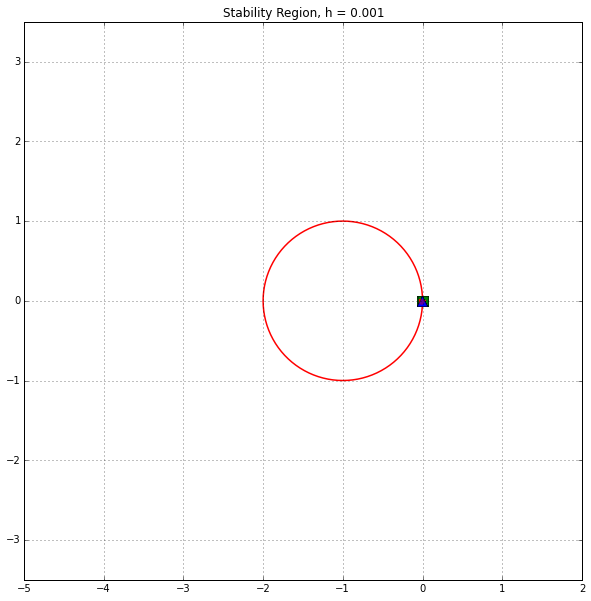

In [10]:
plot_lambda_h_lorenz_system(euler_hs[0],"euler")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


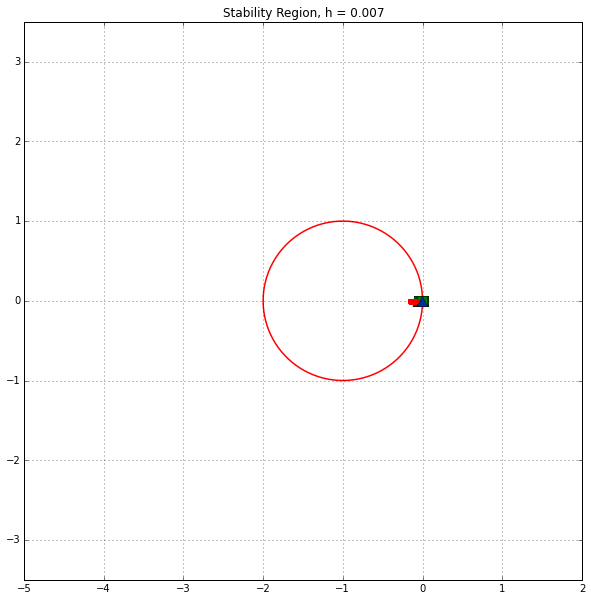

In [11]:
plot_lambda_h_lorenz_system(euler_hs[1],"euler")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


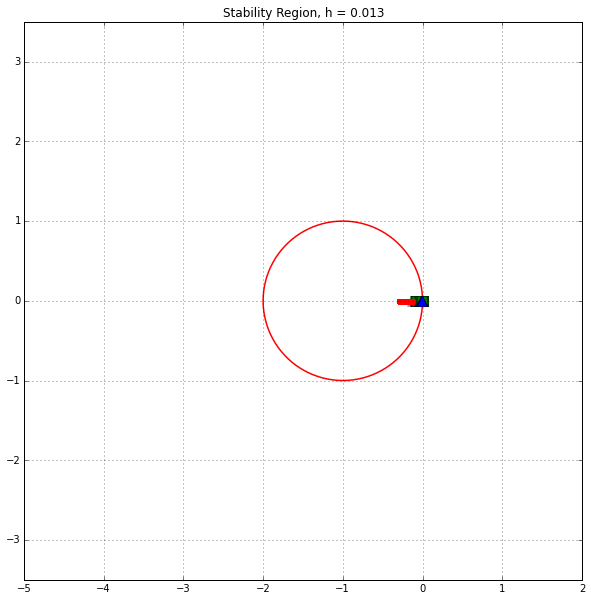

In [12]:
plot_lambda_h_lorenz_system(euler_hs[2],"euler")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


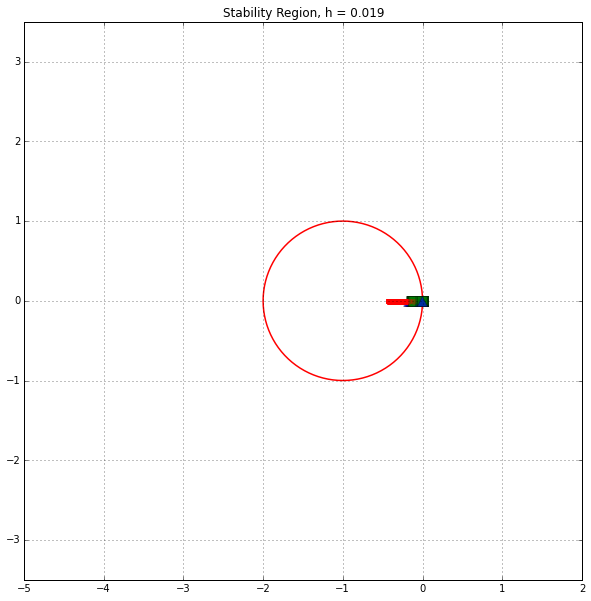

In [13]:
plot_lambda_h_lorenz_system(euler_hs[3],"euler")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


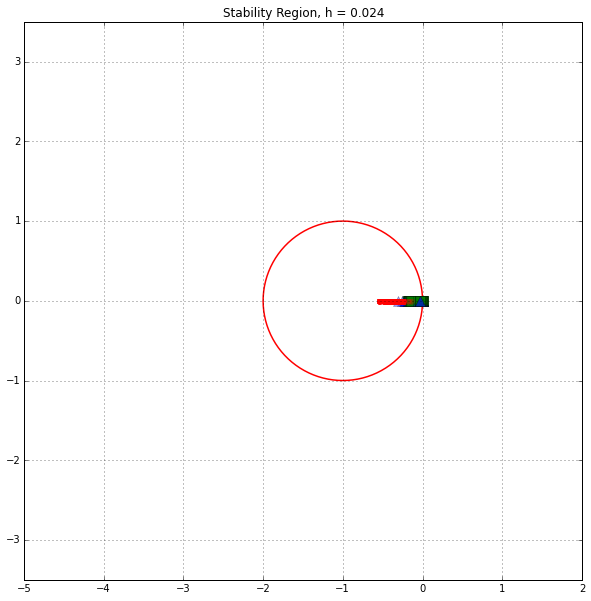

In [16]:
plot_lambda_h_lorenz_system(euler_hs[4],"euler")

In [18]:
midpoint_hs = np.linspace(0.001,0.068,5)   #desestabiliza con h >=  0.07

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


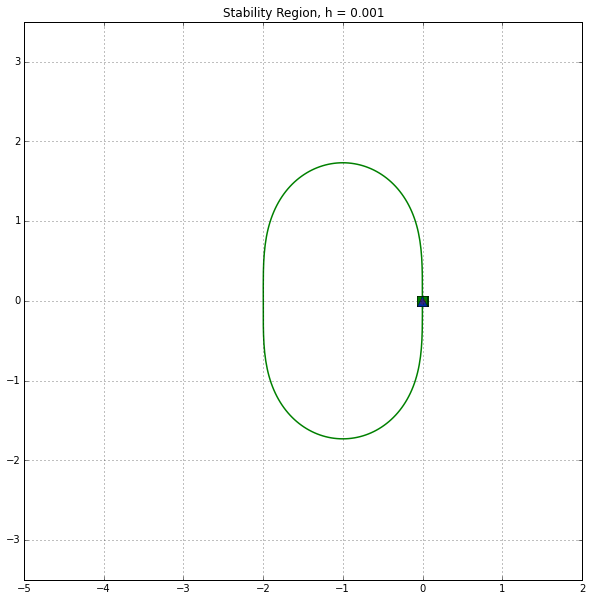

In [19]:
plot_lambda_h_lorenz_system(midpoint_hs[0],"midpoint")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


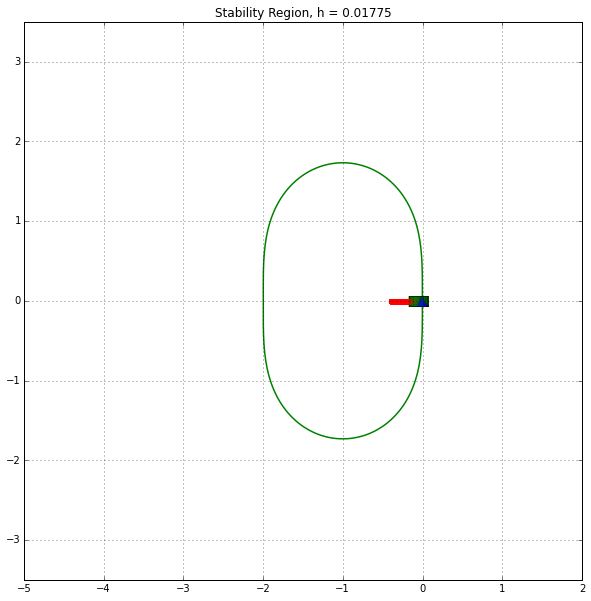

In [20]:
plot_lambda_h_lorenz_system(midpoint_hs[1],"midpoint")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


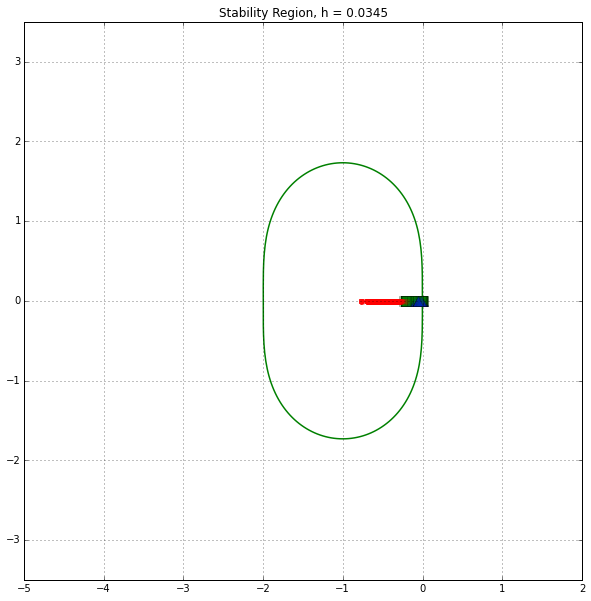

In [21]:
plot_lambda_h_lorenz_system(midpoint_hs[2],"midpoint")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


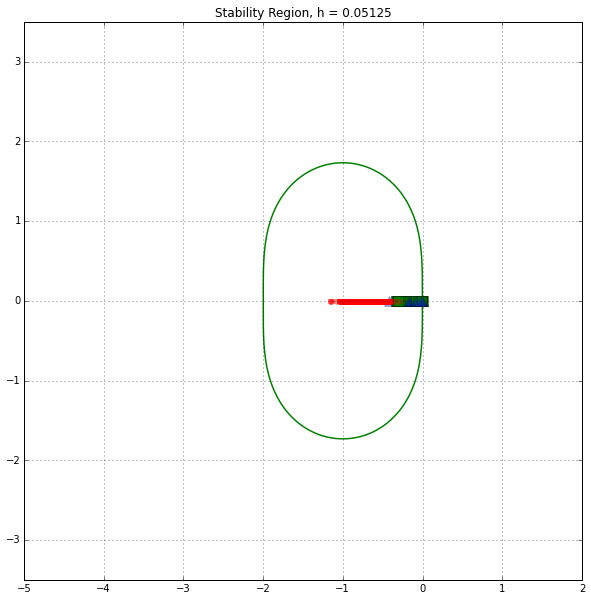

In [22]:
plot_lambda_h_lorenz_system(midpoint_hs[3],"midpoint")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


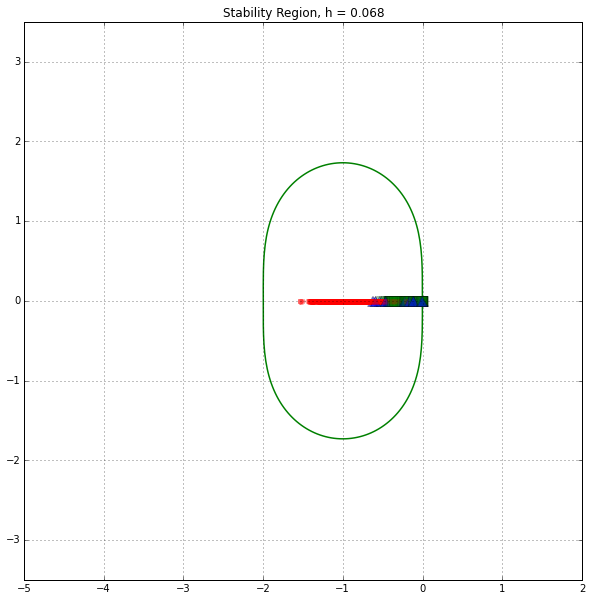

In [23]:
plot_lambda_h_lorenz_system(midpoint_hs[4],"midpoint")

In [32]:
RK4_hs = np.linspace(0.09,0.135,5)  #desestabiliza con h >= 0.14

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


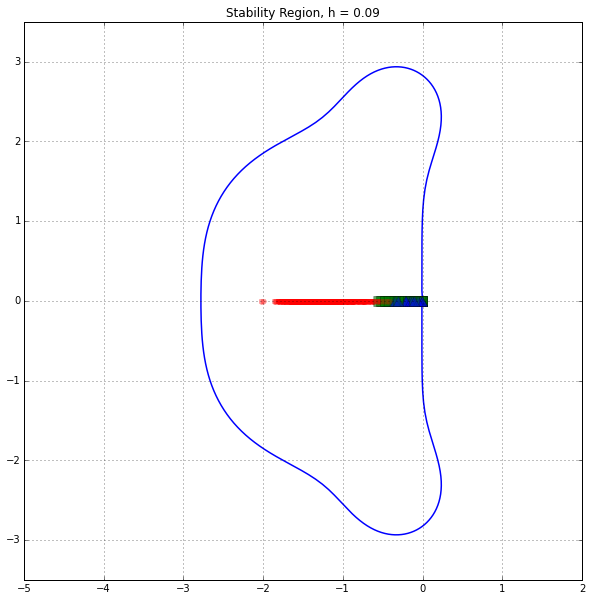

In [33]:
plot_lambda_h_lorenz_system(RK4_hs[0],"RK4")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


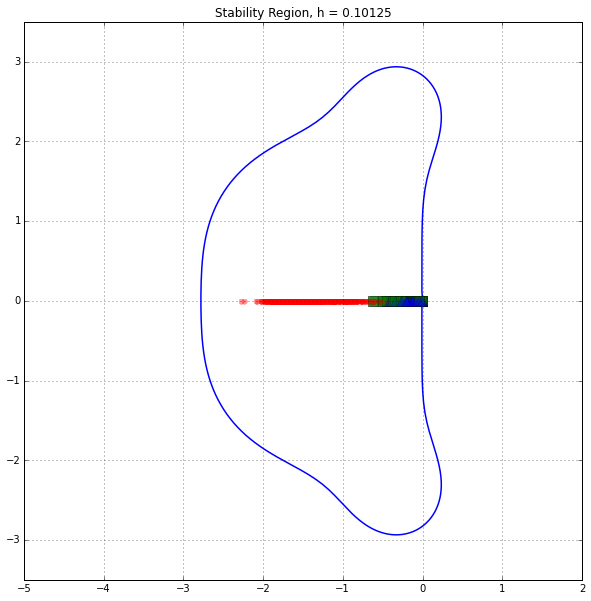

In [34]:
plot_lambda_h_lorenz_system(RK4_hs[1],"RK4")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


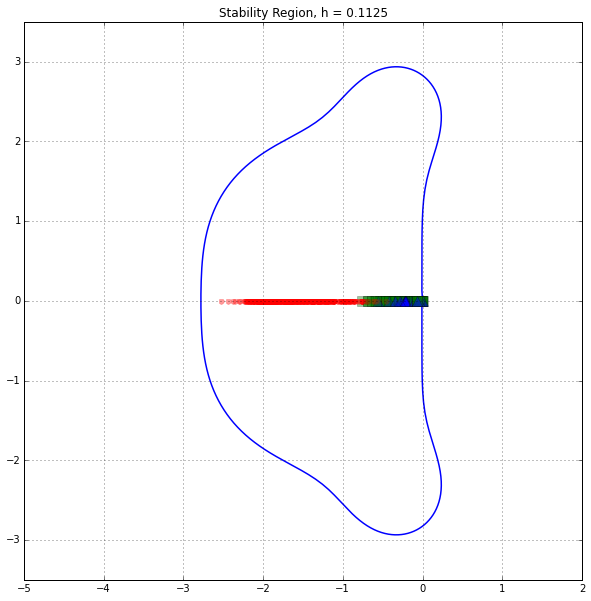

In [35]:
plot_lambda_h_lorenz_system(RK4_hs[2],"RK4")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


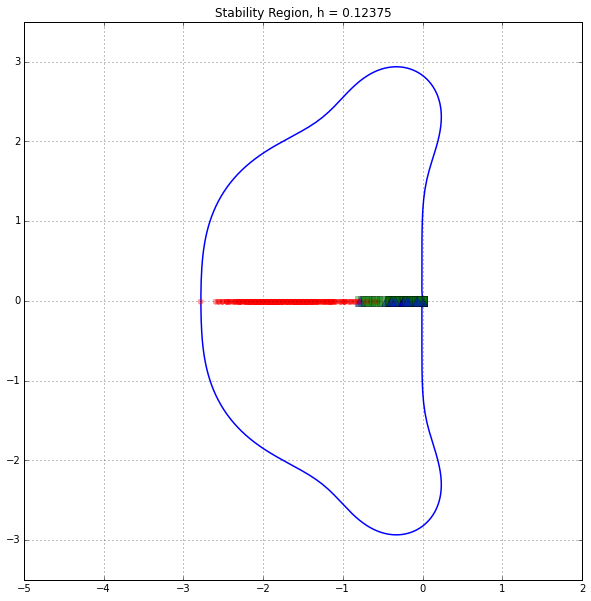

In [36]:
plot_lambda_h_lorenz_system(RK4_hs[3],"RK4")

C:\Users\eddox\Anaconda\lib\site-packages\ipykernel\__main__.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


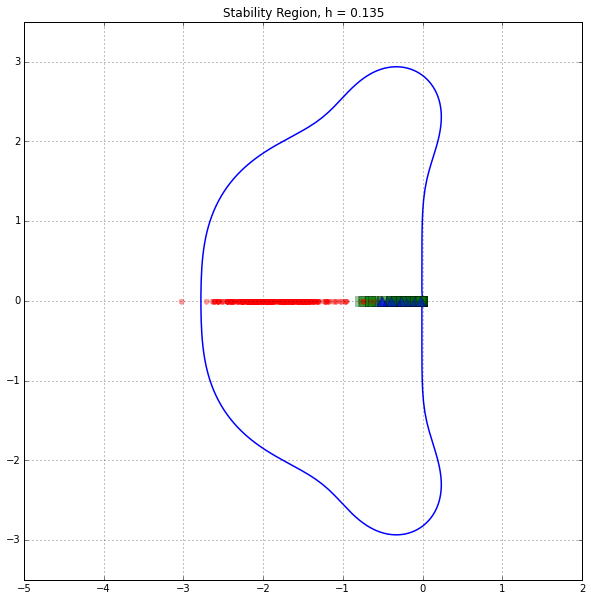

In [37]:
plot_lambda_h_lorenz_system(RK4_hs[4],"RK4")

En todos los gráficos se muestran las curvas que delimitan la región de estabilidad de los tres métodos y los $\lambda$. Se aprecia que en todos los casos la parte imaginaria de los $\lambda$ es despreciable respecto a la real. Se realizan 5 iteraciones desde un $h$ que se sabe que funciona hasta uno cercano a uno que no funciona y desestabiliza el método. Se puede apreciar que mientras más alejado del $h$ que desestabiliza, los $\lambda$ son más cercanos a $0$, mientras que a mayor $h$, tienden a salir de la región. Los mejores resultados en las simulaciones se obtendran con los $h$ menores.

e.-

In [ ]:
def parallel_euler_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1,t_size):
        for i_tray in range(0, num_tray):
            prev_y = solutions[i-1][:,i_tray]
            prev_t = t[i-1]
            solutions[i][:,i_tray] = prev_y + h*func(prev_t,prev_y)
    return solutions

def parallel_midpoint_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1, t_size):
        for i_tray in range(0, num_tray):
            prev_t = t[i-1]
            prev_y = solutions[i-1][:,i_tray]
            k1 = prev_y + h/2.0*func(prev_t,prev_y)
            solutions[i][:,i_tray] = prev_y + h*func(prev_t + h/2.0,k1)
    return solutions

def parallel_RK4_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1, t_size):
        for i_tray in range(0, num_tray):
            prev_t = t[i-1]
            prev_y = solutions[i-1][:,i_tray]
            k1=func(prev_t,prev_y)
            k2=func(prev_t+h/2.0,prev_y+(h/2.0)*k1)        
            k3=func(prev_t+h/2.0,prev_y+(h/2.0)*k2)
            k4=func(prev_t+h,prev_y+h*k3)
            solutions[i][:,i_tray]  = prev_y+(h/6.0)*(k1+2*k2+2*k3+k4)
    return solutions

f.- 

In [ ]:
p1 = np.array([1,1,1])
p2 = np.array([1,1,1-0.000009]) # la componente Z es la que difiere
x_0 = np.zeros((3,2))
x_0[:,0] = p1
x_0[:,1] = p2
t = np.arange(0,50,h)

In [ ]:
x = parallel_euler_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

<img src="images/par_euler.png">

In [ ]:
x = parallel_midpoint_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

<img src="images/par_midpoint.png">

In [ ]:
x = parallel_RK4_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

<img src="images/par_RK4.png">

Se usaron puntos con iguales coordenadas en el plano XY, pero con una diferencia de 0.000009 en el eje Z. Como podemos ver en las animaciones, en las primeras posiciones ambos puntos parecen estar juntos, pero la verdad es que hay una distancia imperceptible. Además ambos puntos se mueven de la misma forma en el espacio. Luego de unas iteraciones, la distancia se vuelve clara y los movimientos dejan de ser iguales, cada punto toma un rumbo distinto. Esto demuestra claramente el comportamiento de sistemas caóticos, ya que una pequeña variación en las condiciones iniciales causa soluciones completamente distintas en el tiempo. El método de Euler genera soluciones que comienzan a diverger a los 9 segundos de simulación aproximadametne, mientras que Midpoint comienza a los 26 y RK4 demora 32. Esto se debe a la presición con las que calculan cada solución, siendo RK4 el más preciso.

Nota: La velocidad de simulación es relativa al computador. Los segundos podrian variar ampliamente. Lo importante es que la divergencia ocurre posteriormente en el método más preciso.

g.-

In [ ]:
r = 0.000009
x_0 = np.zeros((3,20))
for i in range(20):
    x_0[:,i] = np.array([1,1,1+r/19*i])
x = parallel_RK4_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

<img src="images/butterfly.png">

Todos los puntos tienen coordenadas iguales en plano XY, y la coordenada z se reparte entre los 20 puntos de manera equiespaciada entre 1 y 1.000009. A los 50 segundos de simulación aproximadamente se ve la divergencia máxima de todos los puntos. Cada uno toma una ruta distinta, y jamás vuelven a alinearse como en un principio, mostrando un comportamiento caótico.

### BVP de orden superior

a) Partiendo de la aproximación de $ y''(x) = \frac{y(x+h) - 2y(x) + y(x-h)}{h^2} + O(h^2)$, aproximaremos la cuarta derivada. Usando la misma técnica de aproximación:

* Tercera derivada:

$$ \begin{align}
   y'''(x) = \frac{y''(x) - y''(x - h)}{h} \implies y'''(x) &= \frac{\frac{y(x+h) - 2y(x) + y(x-h)}{h^2} - \frac{y(x) - 2y(x-h) + y(x-2h)}{h^2}}{h} \\ 
   &= \frac{y(x+h)-3y(x)+3y(x-h)-y(x-2h)}{h^3}
   \end{align} $$
   
* Cuarta derivada:

$$ \begin{align}
   y^{(4)}(x) = \frac{y'''(x) - y'''(x - h)}{h} \implies y^{(4)}(x) &= \frac{\frac{y(x+h) - 3y(x) + 3y(x-h) - y(x-2h)}{2h^3} - \frac{y(x) - 3y(x-h) + 3y(x-2h) - y(x-3h)}{h^3}}{h} \\ 
   &= \frac{y(x+h) - 4y(x) + 6y(x-h) - 4y(x-2h) + y(x-3h)}{h^4}
   \end{align} $$

Para discretizar, sea $ x_i = i \cdot \Delta x $, con $ \Delta x = \frac{1}{N} $ el largo de los intervalos escogidos y $ N $ el número de puntos; y $ u_i = y(x_i) $ la discretización del dominio de la función, con $ x_i \in [0,2] $. Para el BVP, la discretización tiene la siguiente forma:


$$ \begin{align}
   \frac{u_{i+1} - 4u_{i} + 6u_{i-1} - 4u_{i-2} + u_{i-3}}{h^4} &= -u_i \\
   \frac{1}{h^4}u_{i+1} - \left(\frac{4}{h^4} - 1 \right)u_i + \frac{6}{h^4}u_{i-1} - \frac{4}{h^4}u_{i-2} + \frac{1}{h^4}u_{i-3} &= 0 \qquad \forall i \in 0:N
   \end{align} $$
   
Por lo tanto, la EDO discretizada es de la siguiente forma:
$$ 
\begin{align}
    \frac{1}{h^4}u_{i+1} - \left(\frac{4}{h^4} - 1 \right)u_i + \frac{6}{h^4}u_{i-1} - \frac{4}{h^4}u_{i-2} + \frac{1}{h^4}u_{i-3} &= 0 \qquad \forall i \in 0:N \\
    u_0 &= 0 \\
    u_N &= 1 \\
    \frac{u_N - u_{N-1}}{h} &= -1 \\
    \frac{u_N - 2u_{N-1} - u_{N-2}}{h^2} &= 1
\end{align}
$$

La cual se puede representar en la siguiente forma matricial:

$$
    \begin{pmatrix}
    1 & 0 & 0 & \ldots & & & & & \ldots & 0 \\
    \frac{1}{h^4} & \frac{-4}{h^4} & \frac{6}{h^4} & \frac{-4}{h^4} + 1 & \frac{1}{h^4} & 0 & 0 & 0 & \ldots & 0 \\
    0 & \frac{1}{h^4} & \frac{-4}{h^4} & \frac{6}{h^4} & \frac{-4}{h^4} + 1 & \frac{1}{h^4} & 0 & 0 & \ldots & 0 \\
    0 & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & \ldots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & \ldots & \ldots & 0 & \frac{1}{h^4} & \frac{-4}{h^4} & \frac{6}{h^4} & \frac{-4}{h^4} + 1 & \frac{1}{h^4} & 0 \\
    0 & \ldots & & \ldots & 0 & \frac{1}{h^4} & \frac{-4}{h^4} & \frac{6}{h^4} & \frac{-4}{h^4} + 1 & \frac{1}{h^4} \\
    0 & \ldots & & & \ldots & 0 & 0 & \frac{1}{h^2} & \frac{-2}{h^2} & \frac{1}{h^2} \\
    0 & \ldots & & & & & \ldots & 0 & \frac{1}{h} & \frac{-1}{h} \\
    0 & \ldots & & & & & & \ldots & 0 & 1
    \end{pmatrix}
    \begin{pmatrix}
    y_0 \\ y_1 \\ y_2 \\ \vdots \\ \\ y_{N-4} \\ y_{N-3} \\ y_{N-2} \\ y_{N-1} \\ y_N 
    \end{pmatrix} 
    = 
    \begin{pmatrix}
    0 \\ 0 \\ 0 \\ \vdots \\ \\ \\ 0 \\ 1 \\ -1 \\ 1 
    \end{pmatrix}
$$
<br>
<br>

c) Asumiendo que el dominio del BVP es $ [0,2] $, la función fue implementada de la siguiente forma:

In [5]:
%matplotlib inline 

# Como nuestra matriz es una matriz con bandas, representaremos esta de otra forma, donde cada diagonal será una fila
# de la matriz, siendo esta de dimensión 5xN (ya que hay 5 diagonales), siendo N la dimensión de la matriz y rellenando con 0
# tanto antes como despues de las diagonales no centrales dependiendo en que parte esten (las agregan a la matriz las diagonales
# de arriba hacia abajo). Luego resolveremos el sistema de ecuaciones lineales en base a esta matriz con un solver adecuado.

def solve_BVPIV(N):
    size = N
    delta = 2./(N-1.)
    
    F = np.zeros([5, size])
    F[0,4:] = F[0,4:] + 1./delta**4.
    F[1,3:size-1] = F[1,3:size-1] + 1 + (-4./delta**4.)
    F[1,size-1] = 1./delta**2.
    F[2,2:size-2] = F[2,2:size-2] + 6./delta**4.
    F[2,size-2] = -2./delta**2.
    F[2,size-1] = 1./delta
    F[3,0] = 1
    F[3,1:size-3] = F[3,1:size-3] + -4./delta**4.
    F[3,size-3] = 1./delta**2.
    F[3,size-2] = -1./delta
    F[3,size-1] = 1.
    F[4,:size-4] = 1./delta**4.
    
    b = np.zeros(size)
    b[size-3:] = np.array([1.,-1.,1.])
    
    return linalg.solve_banded((1,3),F,b)

d) Los gráficos son los siguientes:

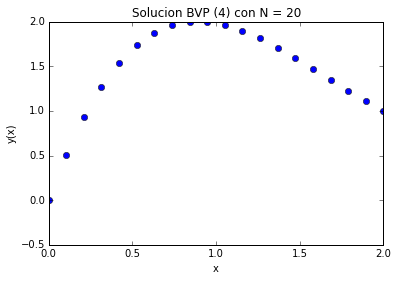

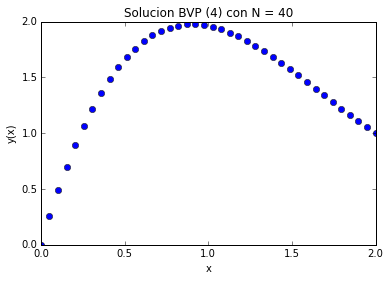

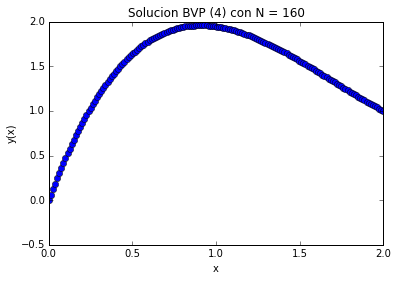

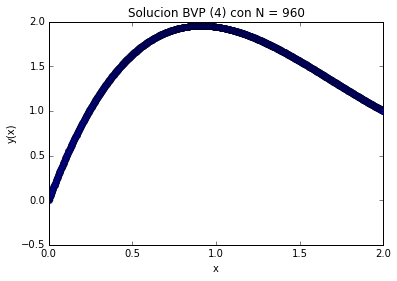

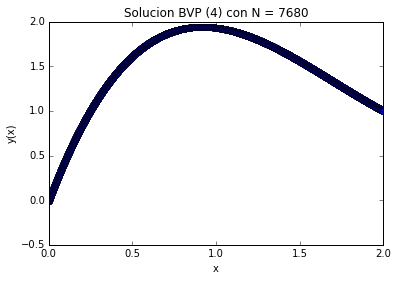

In [6]:
N = (20, 40, 160, 960, 7680)

for i in N:
    plt.plot(np.linspace(0,2,i), solve_BVPIV(i), 'o', label="N = " + str(i))
    plt.title("Solucion BVP (4) con N = " + str(i))
    plt.ylabel("y(x)")
    plt.xlabel("x")
    plt.show()

Como se puede ver, a medida que aumentamos h, podemos aumentar la precisión de la solución $ y(x) $, lo cuál se demuestra en los gráficos de arriba, en donde la función se va por sobre los límites del gráfico con valores que pueden superar un poco el $ 2 $. A medida que aumentamos $ N $, además de poder tener una mejor visión de como se comporta la función, se nota que los valores ya no van por sobre $ 2 $, por lo que nos aseguramos que la función encontrada es más precisa.

## Conclusión

Durante el desarrollo de este laboratorio, logramos comprender como funcionan los métodos de resolución de ODE's, cuales son sus características y como usarlos de la manera más eficiente, tanto para IVPs como BVPs. Por otro lado, también podemos comprobar que tanto las condiciones iniciales y el ancho del intervalo tienen una gran importancia al momento de resolver un IVPs, puesto que usar los incorrectos puede conllevar a resultados completamente lejanos a la realidad.

## Referencias

* http://www.getdatajoy.com : Para realizar pequeños tests de programación antes de implementarlos en el laboratorio.
* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.solve_banded.html : Método de resolución de matrices con bandas
* http://www.wolframalpha.com : Para realizar cálculos analíticos para comprobar los resultados numéricos.